In [1]:
import re
from glob import glob

text_files = glob('*.txt')
# list1.txt -> Only topics, no phrase

In [7]:
# Extracting the texts
texts = []
for file in text_files:
    with open(file, 'r') as f:
        text = f.read()
        texts.append(text)

In [77]:
# Removing the numbers
all_phrases = []
matches = []
for text in texts:
    phrases = text.split('\n')
    phrases = [re.sub(r'^\d{1,4}\. "?', '', phrase) for phrase in phrases]
    phrases = [re.sub(r'^\w+: ?"?', '', phrase) for phrase in phrases]
    phrases = [phrase.strip('\n -"') for phrase in phrases]
    phrases = [phrase for phrase in phrases if phrase if not re.match('^\s+', phrase)]
    phrases = [phrase for phrase in phrases if len(phrase.split(' '))>3]
    all_phrases += phrases

In [84]:
from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.vectorstores import FAISS
import os
from leomodules.embedding import create_vectorstore
from leomodules.mysecrets import OPENAI_API_KEY

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
create_vectorstore(all_phrases, save_path='user_inputs')

embeddings = OpenAIEmbeddings()

The shape of your vector array is: (898, 1536)
The shape of your vector array is: (898, 1536)


In [88]:
import numpy as np

X = np.load('user_inputs/vector_array.npy')

In [122]:
from bkmeans import BKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
scaler = StandardScaler()
ks = range(10,100,7)

def compute_things(cluster_class, key, ks, X):
    inertias = []
    scores = []
    for k in ks:
        parameter = {key:k}
        bkm = cluster_class(**parameter)
        bkm.fit(X)
        labels = bkm.labels_
        # inertias.append(bkm.inertia_)
        try:
            scores.append(silhouette_score(X, labels))
        except ValueError:
            scores.append(0)
    import pandas as pd
    # df = pd.DataFrame({'inertias': inertias, 'silhouette_score':scores}, index = ks)
    df = pd.DataFrame({'silhouette_score':scores}, index = ks)
    # df['inertias'].plot()
    df['silhouette_score'].plot(secondary_y=True)

In [134]:
from sklearn.cluster import AffinityPropagation, MeanShift, HDBSCAN, SpectralClustering
X_s = scaler.fit_transform(X)


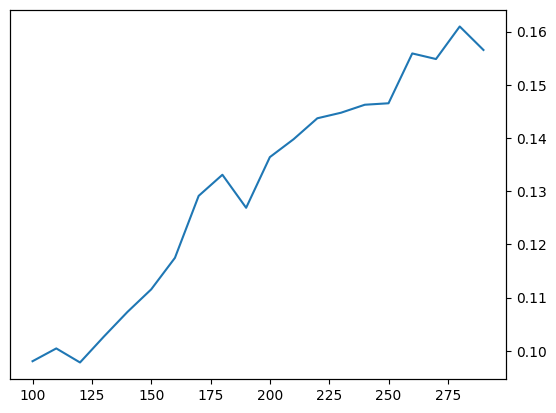

In [165]:
compute_things(BKMeans, 'n_clusters', range(100,300,10), X_s)


/home/llohann/.venvs/sy/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/llohann/.venvs/sy/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/llohann/.venvs/sy/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


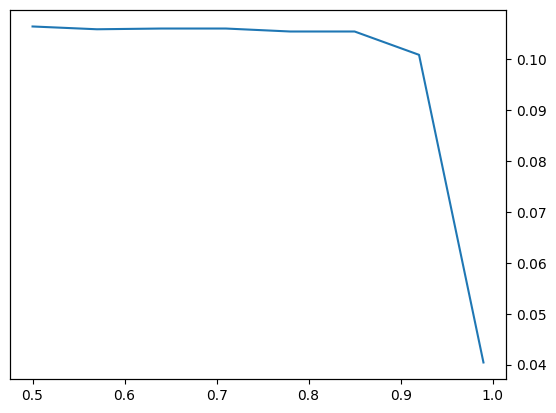

In [129]:
compute_things(AffinityPropagation, 'damping', np.arange(0.5, 1., 0.07), X_s)

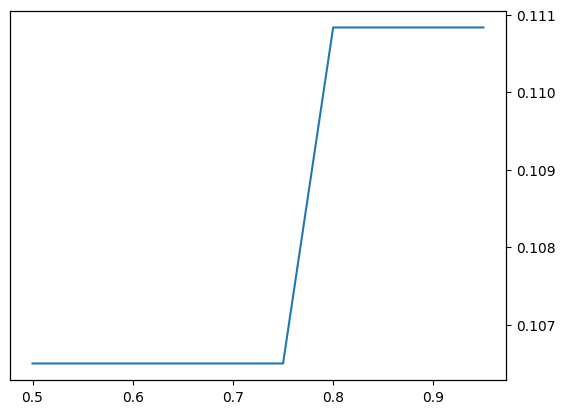

In [136]:
compute_things(MeanShift, 'bandwidth', list(np.arange(0.5, 1., 0.05)) + [None], X)


/home/llohann/.venvs/sy/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/llohann/.venvs/sy/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/llohann/.venvs/sy/lib/python3.10/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/llohann/.venvs/sy/lib/python3.10/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/llohann/.venvs/sy/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:380: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/llohann/.venvs/sy/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:690: RuntimeWarning: overflow encountered in square
  lloyd_iter(
/home/llohann/.venvs/sy/lib/python3.10/site-

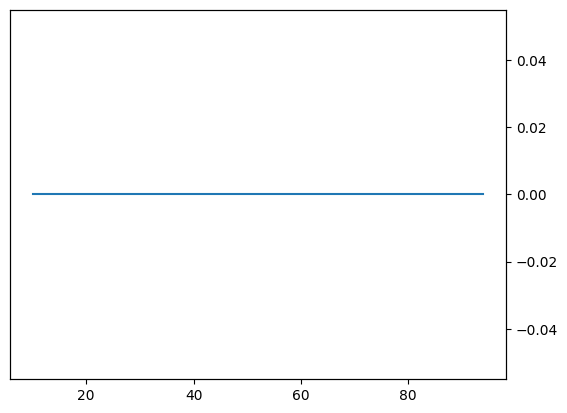

In [131]:
compute_things(SpectralClustering, 'n_clusters', range(10,100,7), X)

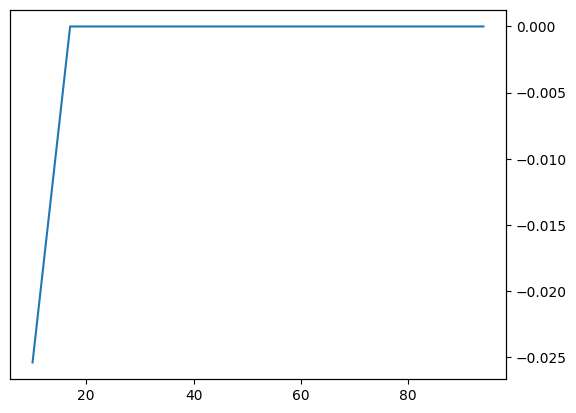

In [132]:
compute_things(HDBSCAN, 'min_cluster_size', range(10,100,7), X_s)

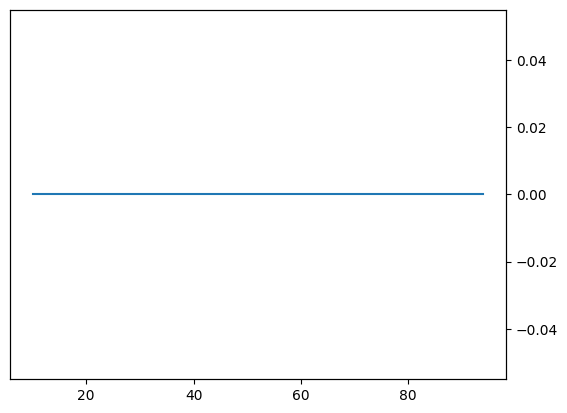

In [138]:
from sklearn.cluster import OPTICS
compute_things(OPTICS, 'min_samples', ks, X_s)

In [162]:
bkm = BKMeans(n_clusters=120, max_iter=1000)
predictions = bkm.fit_predict(X_s)


In [163]:
import pandas as pd
df = pd.DataFrame({'text': all_phrases, 'labels':predictions})

In [164]:
df.sort_values('labels').to_excel('sentences.xlsx')